In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import mlflow
import mlflow.lightgbm
import matplotlib.pyplot as plt
import os

# --- 1. Load Data ---
RAW_PATH = "../data/raw"
# Loading full data but filtering for Store 44 to compare with Prophet
df_train = pd.read_csv(os.path.join(RAW_PATH, "train.csv"))
df_train['date'] = pd.to_datetime(df_train['date'])

# Filter for Store 44
store_id = 44
print(f'Preparing LightGBM for Store {store_id}...')
df_store = df_train[df_train['store_nbr'] == store_id].copy()

# Aggregate to Daily Sales 
df_daily = df_store.groupby('date')[['sales', 'onpromotion']].sum().reset_index()


Preparing LightGBM for Store 44...


Generating Features...


2025/12/28 14:38:22 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/28 14:38:22 INFO mlflow.store.db.utils: Updating database tables
2025/12/28 14:38:22 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/28 14:38:22 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/28 14:38:23 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/28 14:38:23 INFO alembic.runtime.migration: Will assume non-transactional DDL.


 Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 2858.7

 LightGBM Results:
MAE: 2858.70
RMSE: 3993.28


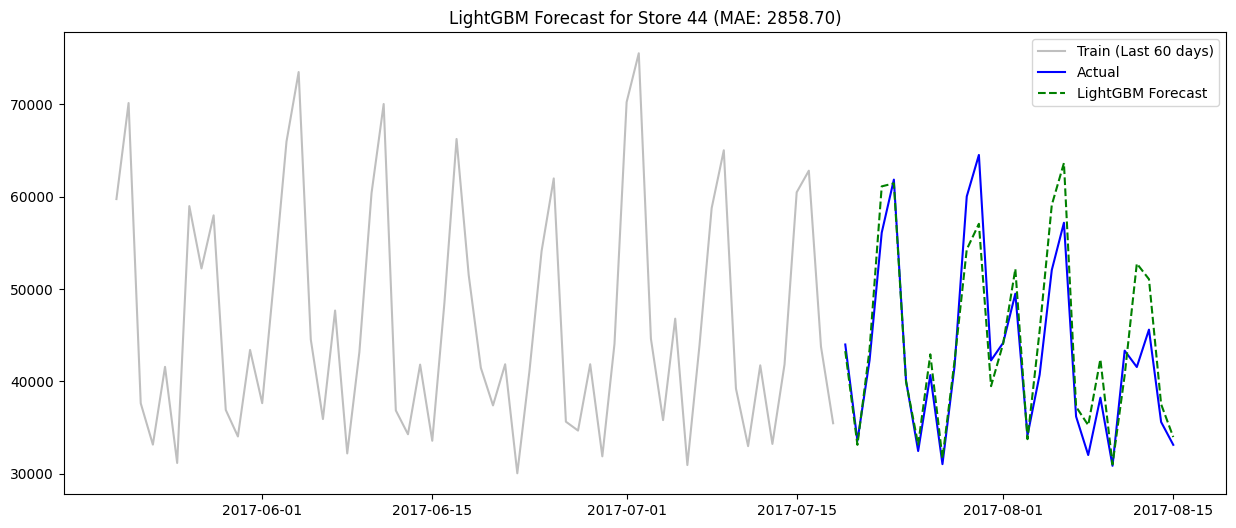

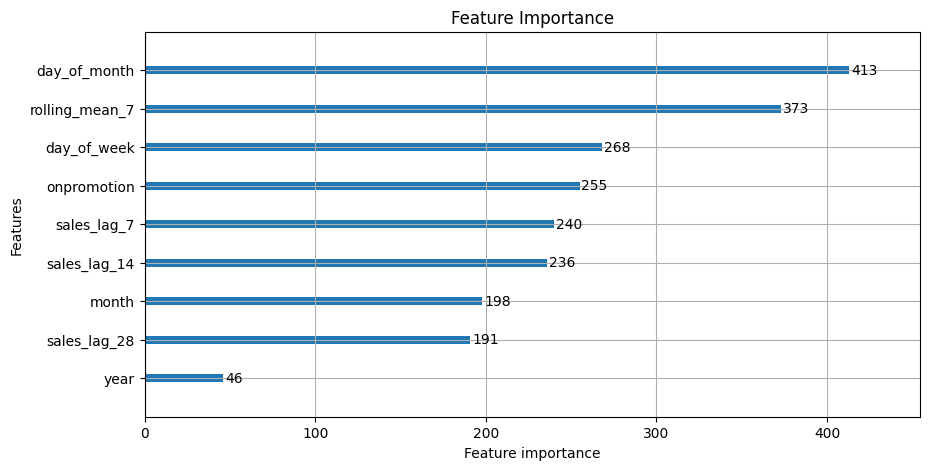

In [2]:

# --- 2. Feature Engineering ---
print("Generating Features...")

# A. Date Features
df_daily['day_of_week'] = df_daily['date'].dt.dayofweek
df_daily['day_of_month'] = df_daily['date'].dt.day
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year

# B. Lag Features
# What was the sales 7 days ago?
df_daily['sales_lag_7'] = df_daily['sales'].shift(7)
df_daily['sales_lag_14'] = df_daily['sales'].shift(14)
df_daily['sales_lag_28'] = df_daily['sales'].shift(28)

# C. Rolling Mean Features
# Acerage sales of the last 7 days(shifted by 1 day to avoid leakage)
df_daily['rolling_mean_7'] = df_daily['sales'].shift(1).rolling(window=7).mean()

# Drop NaN values created by lags
df_model = df_daily.dropna().reset_index(drop=True)

# --- 3. Train/Test Split (Time Based) ---
test_days = 28
train_df = df_model.iloc[:-test_days]
test_df = df_model.iloc[-test_days:]

# Define Features and Target
features = ['day_of_week', 'day_of_month', 'month', 'year', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'rolling_mean_7', 'onpromotion']
target = 'sales'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# --- 4. Training with MLflow ---
mlflow.set_experiment("Reatail_Forecasting_Store_44")

with mlflow.start_run():
    print(" Training LightGBM...")

    # Model Parameters
    params = {
        'objective': 'regression',
        'metric': 'mea',
        'boosting_type': 'gbdt',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'num_leaves': 21,
        'random_state': 42,
        'verbose': -1
    }

    # Log Params
    mlflow.log_params(params)

    # Train
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mae',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print("\n LightGBM Results:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Log Metrics
    mlflow.log_metric('mae', mae)
    mlflow.log_metric('rmse', rmse)

# --- 5. Feature Importance & Visualization ---
plt.figure(figsize=(15, 6))
plt.plot(train_df['date'].iloc[-60:], train_df['sales'].iloc[-60:], label='Train (Last 60 days)', color='gray', alpha=0.5)
plt.plot(test_df['date'], test_df['sales'], label='Actual', color='blue')
plt.plot(test_df['date'], y_pred, label='LightGBM Forecast', color='green', linestyle='--')
plt.title(f"LightGBM Forecast for Store {store_id} (MAE: {mae:.2f})")
plt.legend()
plt.show()

# Plot Feature Importance
lgb.plot_importance(model, max_num_features=10, figsize=(10, 5))
plt.title("Feature Importance")
plt.show()